# Семинар 12: решающие деревья

## Вступление
Сегодня мы познакомимся с новым типом моделей — решающими деревьями. На первый взгляд они имеют совершенно другую природу, чем линейные модели. Однако дальше в курсе мы с вами увидим, что в них больше общего, чем может показаться на первый взгляд. Сами по себе решающие деревья используются в машинном обучении относительно редко, однако очень распространены методы, основанные на их композиции: Random Forest, XGBoost, LightGBM. О них мы поговорим на дальнейших занятиях.

### План семинара
1. Повторяем теорию про решающие деревья
2. Линейные модели VS решающие деревья
3. Переобучение решающих деревьев
4. Неустойчивость решающих деревьев
5. Решение практической задачи при помощи решающих деревьев

## 1. Повторяем теорию про решающие деревья

Пройдемся по основным идеям с лекции. Решающее дерево состоит из вершин, в каждой из которой записан **предикат**: логическое выражение вида $[x_{ij} < t]$. При построении дерева обучающая выборка последовательно разбивается на подгруппы согласно предикатам в дереве. На каждом этапе объекты, приходящие в вершину дерева, разбиваются на две подгруппы: одна отправляется в левое поддерево, вторая — в правое. Выбирать предикаты (находить номер признака $j$ и значение порога $t$) мы будем исходя из **критерия информативности** разбиения. Наша цель — найти такой предикат, который наилучшим образом разобьёт множество объектов $R_m$ на два подмножества $R_l$ и $R_r$. Наилучшим — значит, что внутри группы $R_l$ объекты будут как можно более похожи друг на друга, внутри группы $R_r$ объекты тоже будут как можно более похожи друг на друга, а вот между группами различие будет настолько большим, насколько получится. Различия и сходства объектов для поиска оптимального разбиения обычно формулируются в терминах разнообразия (дисперсии, энтропии и т.д.) целевой переменной.

Давайте попробуем сформулировать всё это на математическом языке. Для фиксированной вершины обозначим множество пришедших в неё объектов $R_m$, множества полученных подгрупп $R_l$ и $R_r$, номер признака разбиения $j$, значение порога для разбиения $t$ и $H(R)$ — критерий неоднородности (impurity criterion). Тогда мы можем записать условие того, что мы хотим разбить объекты $R_m$ на две группы, внутри которых объекты будут наиболее однородными:

$$H(R_m) - \frac{|R_l|}{|R_m|}H(R_l) - \frac{|R_r|}{|R_m|}H(R_r) \to \max.$$

Разумеется, конкретный набор элементов в $R_l$ и $R_r$ зависит от предиката, который мы построили. Предикат, в свою очередь, однозначно определяется двумя числами: $j$ и $t$. Также заметим, что в записанном выше выражении мы не можем контролировать $H(R_m)$, потому что это просто функция от тех объектов, которые пришли в вершину, и она не зависит от предиката. Тогда мы можем переписать наше условие в чуть более простом виде:

$$Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}.$$

Остался последний неясный момент: что же такое $H(R)$ и как её вычислять? Ответ зависит от задачи, которую мы решаем.

#### Регрессия
1. MSE — дисперсия целевой переменной
$$H(R) = \frac{1}{|R|} \sum_{(x_i, y_i) \in R}{}(y_i - \hat{y})^2$$

2. MAE — отклонение от медианы
$$H(R) = \frac{1}{|R|} \sum_{(x_i, y_i) \in R}{}\frac{|y_i - MEDIAN(Y)|}{|R|}$$

#### Классификация
Обозначим $p_k$ долю объектов класса $k$ во множестве объектов $R$.
1. Энтропия
$$H(R) = -\sum_{k=1}^{K} p_k log(p_k)$$

2. Критерий Джини
$$H(R) = -\sum_{k=1}^{K} p_k log(p_k)$$

Давайте на практике убедимся, что энтропийный критерий и правда работает: для однородной выборки возвращает значение больше, чем для выборки с явной в одном из классов.

In [1]:
import numpy as np

g1 = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
g2 = np.array([0.1, 0.6, 0.1, 0.1, 0.1])

res1 = -np.sum(g1 * np.log(g1))
res2 = -np.sum(g2 * np.log(g2))
print(res1, res2)

1.6094379124341005 1.2275294114572126


### Ответьте на вопросы:
1.  Какие методы регуляризации деревьев вы знаете?
2.  Сильно ли изменится дерево от небольшого изменения данных?
3.  Как происходит предсказание с использованием дерева в задачах регрессии и классификации?
4.  Как бы вы оценивали важность признаков при использовании решающего дерева?

### Визуализация решающего дерева
![](https://drive.google.com/uc?id=13kmqLXa-3FBUJq0Q3XVOkz8TENpVTkqk)

## 2. Линейные модели VS решающие деревья

Раньше мы разбирали только линейные модели, которые имеют совсем другую природу по отношению к решающим деревьям. Можно ли сказать, что какой-то из этих двух типов моделей всегда лучше? Нет. В зависимости от пространственной структуры данных, один из них будет работать лучше:

- Линейная модель, если данные хорошо линейно разделимы
- Решающие деревья, если данные плохо линейно разделимы (присутствуют только кусочно-линейные или нелинейные зависимости)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 6.5)

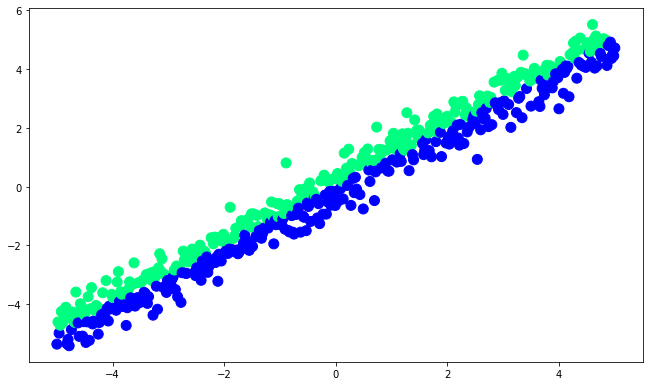

In [3]:
np.random.seed(13)
n = 500
X = np.zeros(shape=(n, 2))
X[:, 0] = np.linspace(-5, 5, 500)
X[:, 1] = X[:, 0] + 0.5 * np.random.normal(size=n)
y = (X[:, 1] > X[:, 0]).astype(int)
plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap="winter");

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=13
)

lr = LogisticRegression(random_state=13)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(f"Linear model accuracy: {accuracy_score(y_pred_lr, y_test):.2f}")

Linear model accuracy: 0.99


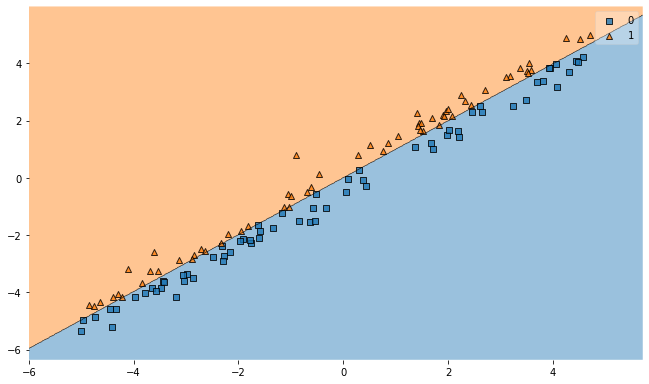

In [5]:
plot_decision_regions(X_test, y_test, lr);

In [6]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=13)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print(f"Decision tree accuracy: {accuracy_score(y_pred_dt, y_test):.2f}")

Decision tree accuracy: 0.86


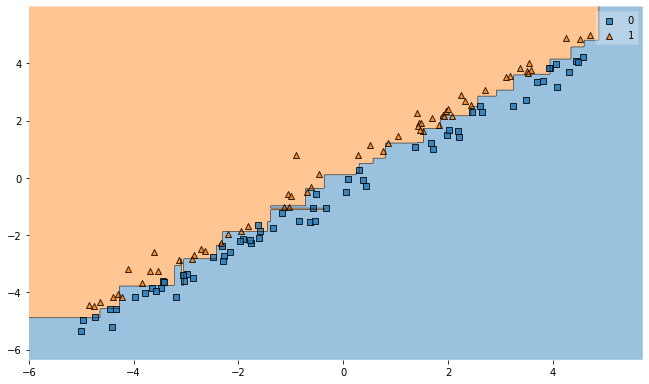

In [7]:
plot_decision_regions(X_test, y_test, dt);

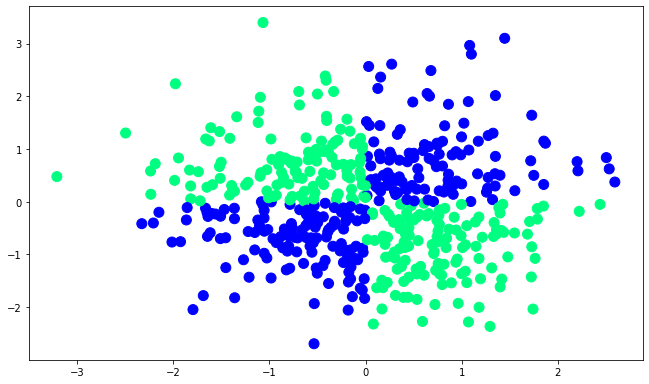

In [8]:
np.random.seed(13)
X = np.random.randn(500, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)
plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap="winter");

Linear model accuracy: 0.39


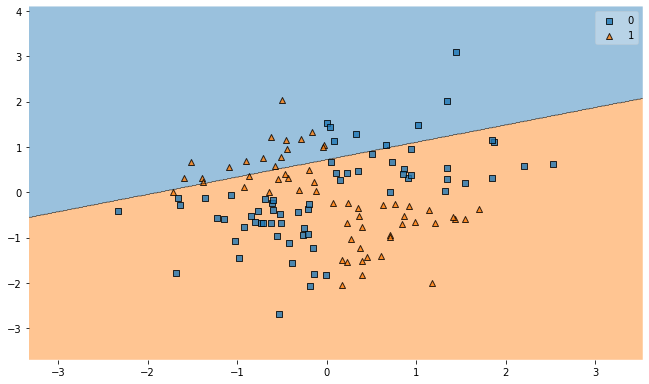

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=13
)

lr = LogisticRegression(random_state=13)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(f"Linear model accuracy: {accuracy_score(y_pred_lr, y_test):.2f}")

plot_decision_regions(X_test, y_test, lr);

Linear model accuracy: 0.97


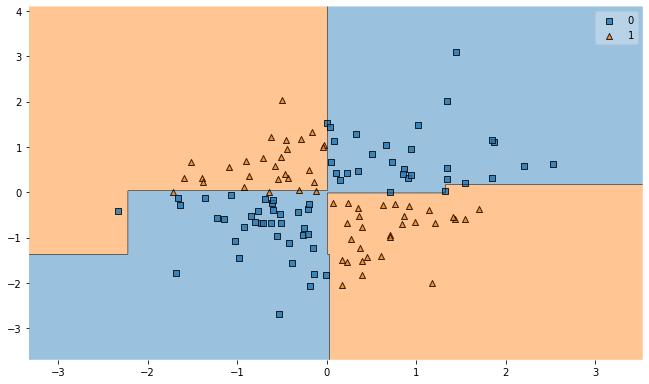

In [10]:
dt = DecisionTreeClassifier(random_state=13)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print(f"Linear model accuracy: {accuracy_score(y_pred_dt, y_test):.2f}")

plot_decision_regions(X_test, y_test, dt);

## 3. Переобучение решающих деревьев
На лекции рассказывалось, что решающие деревья способны переобучиться под любую выборку, если их никак не регуляризовать: при большом количестве листьев для каждого объекта может выделиться своя область в признаковом пространстве. По сути дерево просто выучивает обучающую выборку, не выделяет никаких закономерностей среди данных. Давайте убедимся в этом эффекте на практике, сгенерировав два трудноразделимых множества объектов.

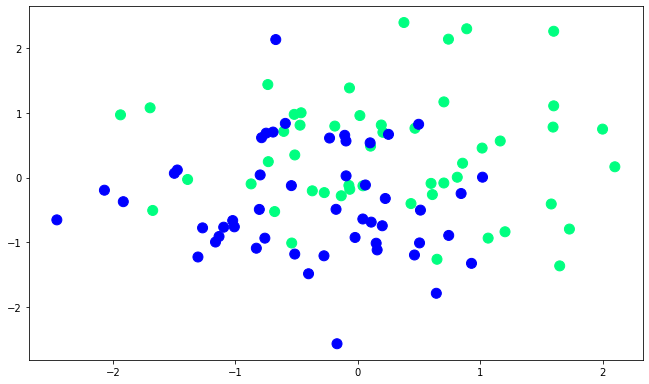

In [11]:
np.random.seed(13)
n = 100
X = np.random.normal(size=(n, 2))
X[:50, :] += 0.25
X[50:, :] -= 0.25
y = np.array([1] * 50 + [0] * 50)
plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap="winter");

Посмотрим, как влияют разные значения гиперпараметров решающего дерева на его структуру:

- `max_depth`: максимальная глубина дерева
- `min_samples_leaf`: минимальное число объектов в вершине дерева, необходимое для того, чтобы она стала листовой

model accuracy: 0.74
model accuracy: 0.79
model accuracy: 0.80
model accuracy: 0.74
model accuracy: 0.83
model accuracy: 0.93
model accuracy: 0.74
model accuracy: 0.83
model accuracy: 1.00


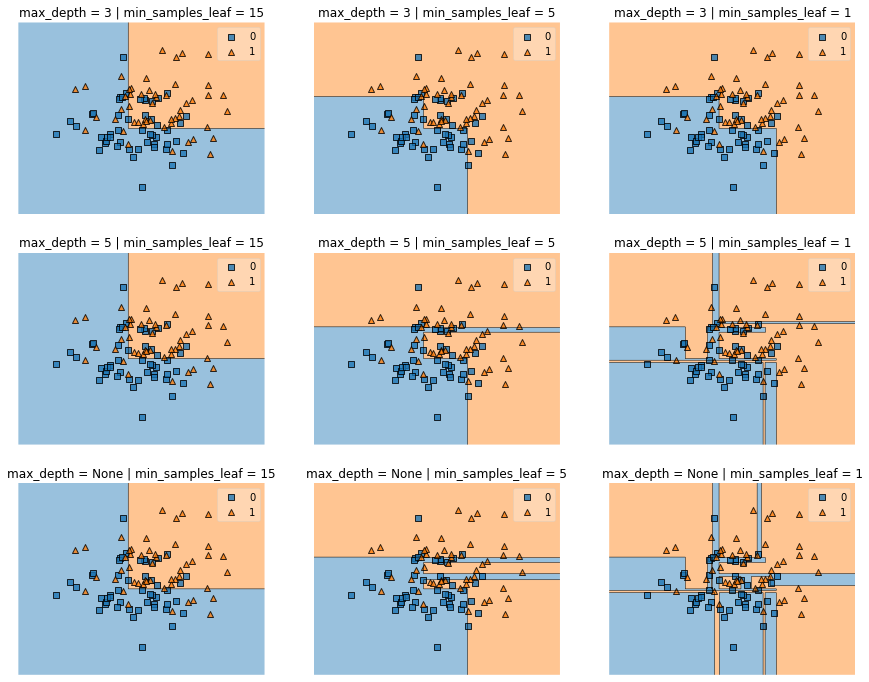

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i, max_depth in enumerate([3, 5, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        dt = DecisionTreeClassifier(
            max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=13
        )
        dt.fit(X, y)
        print(f"model accuracy: {accuracy_score(dt.predict(X), y):.2f}")
        ax[i][j].set_title(
            "max_depth = {} | min_samples_leaf = {}".format(max_depth, min_samples_leaf)
        )
        ax[i][j].axis("off")
        plot_decision_regions(X, y, dt, ax=ax[i][j])

plt.show()

На любой выборке (исключая те, где есть объекты с одинаковыми значениями признаков, но разными ответами) можно получить нулевую ошибку с помощью максимально переобученного дерева:

Decision tree accuracy: 1.00


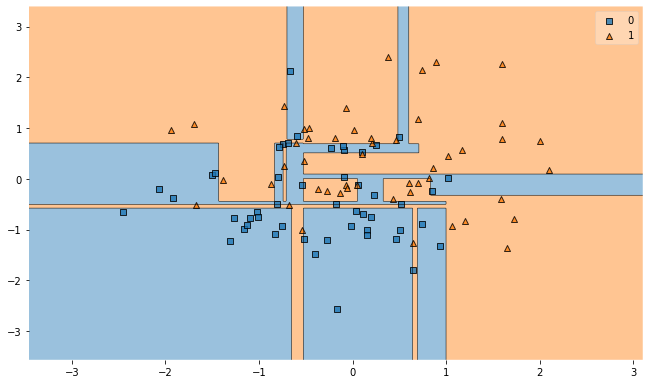

In [15]:
dt = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, random_state=13)
dt.fit(X, y)

print(f"Decision tree accuracy: {accuracy_score(y, dt.predict(X)):.2f}")

plot_decision_regions(X, y, dt);

 ## 4. Неустойчивость решающих деревьев

Посмотрим, как будет меняться структура дерева, если брать для обучения разные 90%-ые подвыборки исходной выборки.

model accuracy: 0.80
model accuracy: 0.82
model accuracy: 0.78
model accuracy: 0.80
model accuracy: 0.80
model accuracy: 0.79
model accuracy: 0.82
model accuracy: 0.80
model accuracy: 0.86


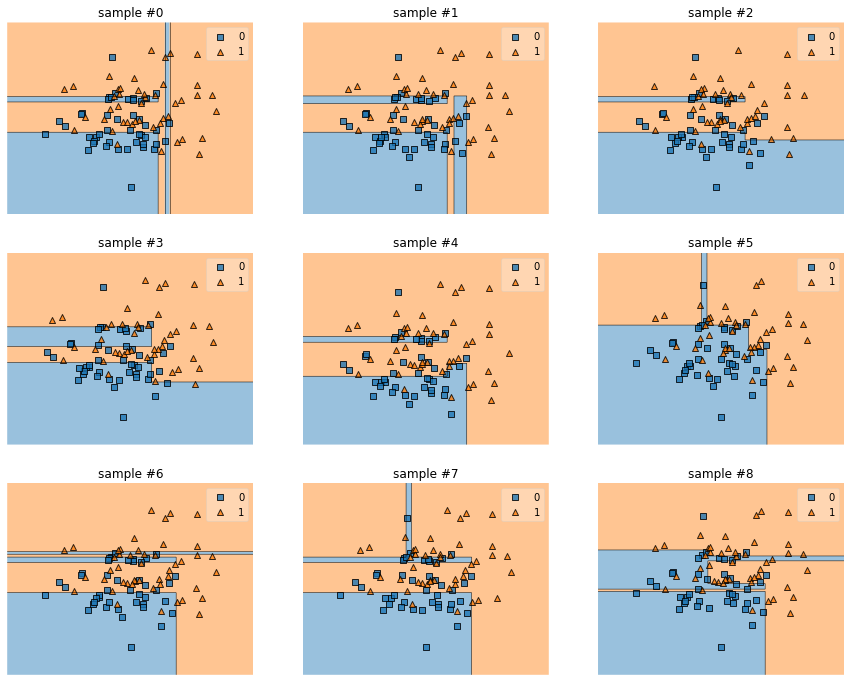

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i in range(3):
    for j in range(3):
        seed_idx = 3 * i + j
        np.random.seed(seed_idx)
        dt = DecisionTreeClassifier(random_state=13, max_depth=4, min_samples_leaf=3)
        idx_part = np.random.choice(len(X), replace=False, size=int(0.9 * len(X)))
        X_part, y_part = X[idx_part, :], y[idx_part]
        dt.fit(X_part, y_part)
        print(f"model accuracy: {accuracy_score(dt.predict(X_part), y_part):.2f}")
        ax[i][j].set_title("sample #{}".format(seed_idx))
        ax[i][j].axis("off")
        plot_decision_regions(X_part, y_part, dt, ax=ax[i][j])

plt.show()

## 5. Решение практической задачи при помощи решающих деревьев

In [19]:
california = fetch_california_housing()
california_X = pd.DataFrame(data=california.data, columns=california.feature_names)
california_Y = california.target
print(f"X shape: {california_X.shape}, Y shape: {california_Y.shape}")
california_X.head()

X shape: (20640, 8), Y shape: (20640,)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [20]:
california_Y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

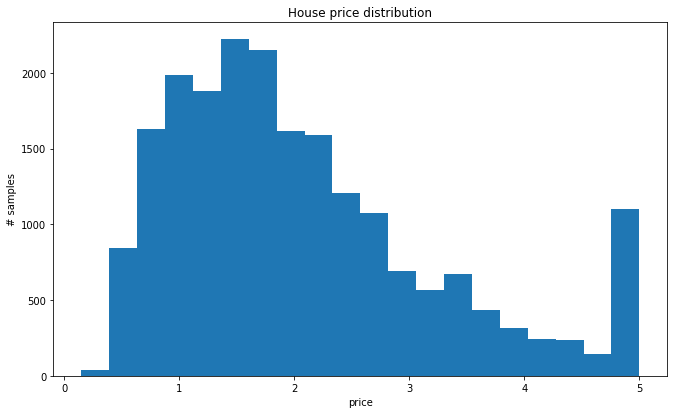

In [21]:
plt.title("House price distribution")
plt.xlabel("price")
plt.ylabel("# samples")
plt.hist(california_Y, bins=20)
plt.show()

In [22]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

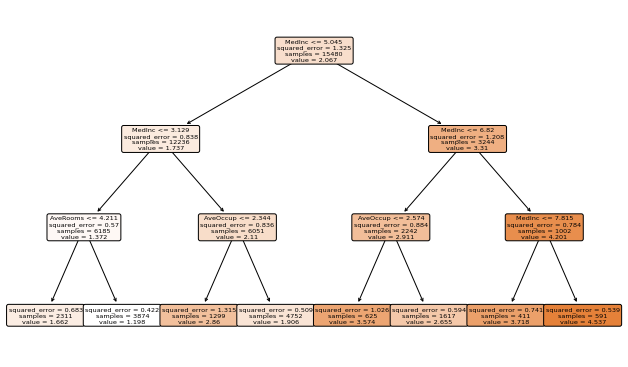

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    california_X, california_Y, test_size=0.25, random_state=13
)

dt = DecisionTreeRegressor(max_depth=3, random_state=13)
dt.fit(X_train, y_train)

plot_tree(dt, feature_names=california_X.columns, filled=True, rounded=True)
plt.show()

In [24]:
mean_squared_error(y_test, dt.predict(X_test))

0.6352419064695592

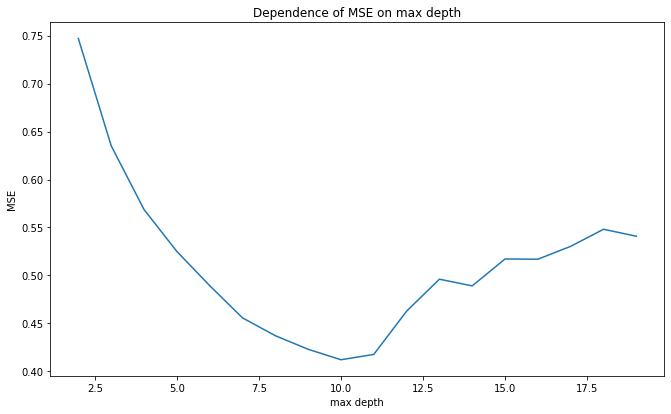

In [25]:
max_depth_array = range(2, 20)
mse_array = []

for max_depth in max_depth_array:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=13)
    dt.fit(X_train, y_train)
    mse_array.append(mean_squared_error(y_test, dt.predict(X_test)))

plt.plot(max_depth_array, mse_array)
plt.title("Dependence of MSE on max depth")
plt.xlabel("max depth")
plt.ylabel("MSE");

In [26]:
pd.DataFrame({"max_depth": max_depth_array, "MSE": mse_array}).sort_values(
    by="MSE"
).reset_index(drop=True)

,max_depth,MSE
0,10,0.412125
1,11,0.417647
2,9,0.423044
3,8,0.437202
4,7,0.455806
5,12,0.462736
6,14,0.489129
7,6,0.489436
8,13,0.496086
9,16,0.516918


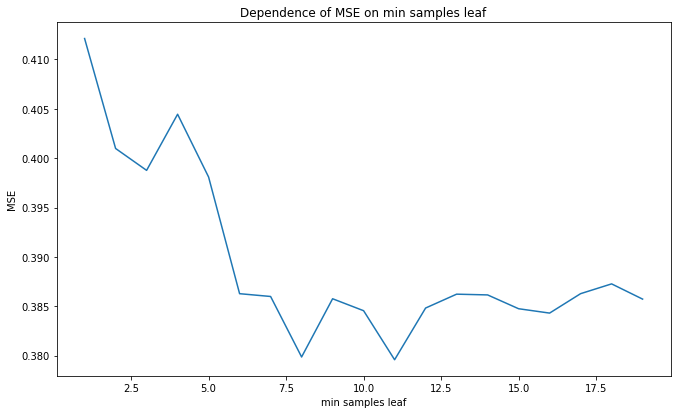

In [28]:
min_samples_leaf_array = range(1, 20)
mse_array = []

for min_samples_leaf in min_samples_leaf_array:
    dt = DecisionTreeRegressor(
        max_depth=10, min_samples_leaf=min_samples_leaf, random_state=13
    )
    dt.fit(X_train, y_train)
    mse_array.append(mean_squared_error(y_test, dt.predict(X_test)))

plt.plot(min_samples_leaf_array, mse_array)
plt.title("Dependence of MSE on min samples leaf")
plt.xlabel("min samples leaf")
plt.ylabel("MSE");

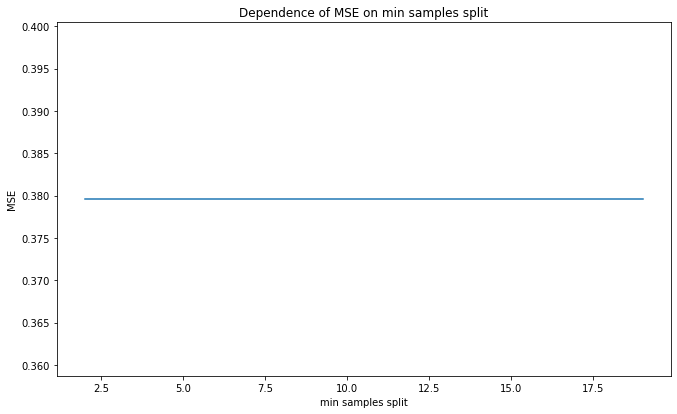

In [33]:
min_samples_split_array = range(2, 20)
mse_array = []

for min_samples_split in min_samples_split_array:
    dt = DecisionTreeRegressor(
        max_depth=10, min_samples_leaf=11, min_samples_split=min_samples_split, random_state=13
    )
    dt.fit(X_train, y_train)
    mse_array.append(mean_squared_error(y_test, dt.predict(X_test)))

plt.plot(min_samples_split_array, mse_array)
plt.title("Dependence of MSE on min samples split")
plt.xlabel("min samples split")
plt.ylabel("MSE");

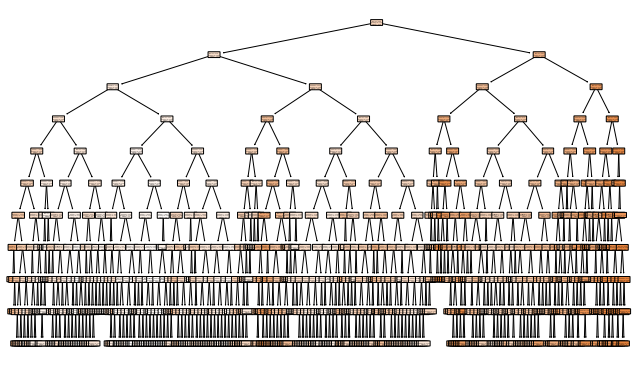

In [34]:
dt = DecisionTreeRegressor(max_depth=10, min_samples_leaf=11, random_state=13)
dt.fit(X_train, y_train)
plot_tree(dt, feature_names=california_X.columns, filled=True, rounded=True);

In [35]:
mean_squared_error(y_test, dt.predict(X_test))

0.37958297902999744

In [36]:
dt.feature_importances_

array([0.61698392, 0.04741643, 0.02829705, 0.00722675, 0.00948772,
       0.13717369, 0.07549099, 0.07792345])

In [37]:
pd.DataFrame(
    {"feature": california_X.columns, "importance": dt.feature_importances_}
).sort_values(by="importance", ascending=False).reset_index(drop=True)

,feature,importance
0,MedInc,0.616984
1,AveOccup,0.137174
2,Longitude,0.077923
3,Latitude,0.075491
4,HouseAge,0.047416
5,AveRooms,0.028297
6,Population,0.009488
7,AveBedrms,0.007227


Влияет ли стандартизация (масштабирование) признаков на результат работы решающего дерева?

In [38]:
from sklearn.preprocessing import StandardScaler

In [39]:
X_train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
5707,3.5174,36.0,4.547945,1.094368,1357.0,2.065449,34.21,-118.23
3754,2.9728,36.0,4.299465,0.997326,1217.0,3.254011,34.18,-118.37
11866,1.6944,11.0,21.372093,4.627907,69.0,1.604651,40.19,-121.08
19325,3.7143,49.0,6.201087,1.298913,505.0,2.744565,38.53,-122.94
1962,2.9219,17.0,6.113960,1.128205,862.0,2.455840,38.73,-120.71


In [40]:
sc = StandardScaler()
X_train_scaled = pd.DataFrame(
    sc.fit_transform(X_train), columns=X_train.columns, index=X_train.index
)
X_test_scaled = pd.DataFrame(
    sc.transform(X_test), columns=X_test.columns, index=X_test.index
)
X_train_scaled.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
5707,-0.181483,0.579137,-0.340021,-0.004463,-0.065383,-0.087113,-0.671762,0.675607
3754,-0.468327,0.579137,-0.436304,-0.200565,-0.187060,0.012248,-0.685728,0.605994
11866,-1.141668,-1.409735,6.179161,7.136066,-1.184805,-0.125634,2.112156,-0.741514
19325,-0.077775,1.613350,0.300554,0.408878,-0.805871,-0.030340,1.339362,-1.666371
1962,-0.495137,-0.932406,0.266794,0.063914,-0.495596,-0.054477,1.432470,-0.557537


In [41]:
print("No scaling is applied\n")

for max_depth in [3, 6]:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=13)
    dt.fit(X_train, y_train)
    print(
        f"MSE on test set for depth {max_depth}: {mean_squared_error(y_test, dt.predict(X_test)):.2f}"
    )

No scaling is applied

MSE on test set for depth 3: 0.64
MSE on test set for depth 6: 0.49


In [42]:
print("Standard scaling is applied\n")

for max_depth in [3, 6]:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=13)
    dt.fit(X_train_scaled, y_train)
    print(
        f"MSE on test set for depth {max_depth}: {mean_squared_error(y_test, dt.predict(X_test_scaled)):.2f}"
    )

Standard scaling is applied

MSE on test set for depth 3: 0.64
MSE on test set for depth 6: 0.49
